In [6]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, transpile
from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.primitives import Estimator
from qiskit.circuit import Parameter, ParameterVector
import numpy as np
from qiskit.tools.visualization import plot_histogram, plot_state_city
from qiskit.extensions import HamiltonianGate
from qiskit.opflow import X, Y, Z, I
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.quantum_info import Statevector
import matplotlib.pyplot as plt
from functools import partial
from scipy.optimize import minimize as opt
from time import time

def create_hamiltonian(N): #crea l'hamiltoniana generale di ising dati i campi e n di qubits
    for q in range(N): #questo for crea i termini Hz,Hx,Hzz insieme H=gzz*Hz-gx*Hx-gz*Hz
        if q==0:
            opz=Z
            opx=X
            opzz=Z
        else:
            opz=I
            opx=I
            opzz=I
        if q==N-1:
            opzz=Z
        for i in range(1,N):
            if i==q:
                opz=opz^Z
                opx=opx^X
            else:
                opz=opz^I
                opx=opx^I
            if i==q or i==q+1:
                opzz=opzz^Z
            else:
                opzz=opzz^I
        if q==0:
            Hz=opz
            Hx=opx
            Hzz=opzz
        else:
            Hz=Hz+opz
            Hx=Hx+opx
            Hzz=Hzz+opzz
    return Hz,Hx,Hzz

def create_graph(N):
    g=[]
    for i in range(N):
        g.append((i,i+1))
        if i==N-2:
            g.append((N-1,0))
            break
    return g

def create_parameterized_circuit(N,p): #crea il circuito parametrico
    gamma=ParameterVector('gamma',p)
    beta=ParameterVector('beta',p)
    qr=QuantumRegister(N, 'q')
    qc=QuantumCircuit(qr)
    qc.h(qr[0:N])
    g=create_graph(N)
    for i in range(p):
        for edge in g: #cost layer, evolution with gzz*Hzz
            qc.cx(edge[0],edge[1])
            qc.rz(-2*gzz*gamma[i],edge[1])
            qc.cx(edge[0],edge[1])
        qc.rz(-2*gz*gamma[i],qr[0:N]) #cost layer, evolution with -gz*Hz
        qc.rx(-2*gx*beta[i],qr[0:N]) #mixer layer
    return qc

def expectation_value(parameters,estimator,qc,Htot): #calcola il valore dell'energia tramite l'estimator
    qc_f=qc.assign_parameters(parameters)
    job = estimator.run(qc_f,Htot)
    result=job.result()
    return result.values[0]

def generate_random_parameters(p): #genera i parametri casualmente tra 0 e pi
    initial_parameters=np.empty(p) #al circuito vanno dati prima i beta in ordine e poi i gamma in ordine
    for i in range(p):
        initial_parameters[i]=np.random.uniform(0,2*np.pi)
    return initial_parameters

def compute_new_parameters(old_parameters,P): #metodo INTERP
    new_parameters=np.empty(P)
    new_parameters[0]=old_parameters[0]
    for i in range(P-1):
        new_parameters[i]=(i/(P-1))*old_parameters[i-1]+((P-1-i)/(P-1))*old_parameters[i]
    new_parameters[P-1]=old_parameters[P-2]
    return new_parameters

def optimization_via_INTERP(N,P_max):
    Hz,Hx,Hzz=create_hamiltonian(N)
    Htot=gzz*Hzz+gx*Hx+gz*Hz
    optimizer=partial(opt,method='L-BFGS-B')
    qc=create_parameterized_circuit(N,1)
    estimator=Estimator()
    gammas=[0.1]
    betas=[0.1]
    new_parameters=betas+gammas
    start_time=time()
    Result=VQE(estimator,qc,optimizer,initial_point=new_parameters).compute_minimum_eigenvalue(Htot)
    optimized_parameters=Result.optimal_point
    step=Result.cost_function_evals
    for P in range(2,P_max+1):
        qc=create_parameterized_circuit(N,P)
        gammas=compute_new_parameters(gammas,P)
        betas=compute_new_parameters(betas,P)
        new_parameters=np.concatenate((betas,gammas))
        Result=VQE(estimator,qc,optimizer,initial_point=new_parameters).compute_minimum_eigenvalue(Htot)
        optimized_parameters=Result.optimal_point
        step=step+Result.cost_function_evals
    comput_time=time()-start_time
    return Result,comput_time,step

def find_the_GS(H):
    matrix_to_diag=H.to_matrix().real
    diag_matrix=np.linalg.eig(matrix_to_diag)
    index=np.argmin(diag_matrix[0])
    return diag_matrix[1][:,index]

def fidelity(H,QAOA_state):
    GS_real=find_the_GS(H)
    fid=np.vdot(QAOA_state,GS_real)
    return (fid.real)**2+(fid.imag)**2

In [2]:
gx=-0.5 #campo trasverso
gz=0 #campo longitudinale
gzz=-1 

In [3]:
def wrong_INTERP(P_max): #aggiungo di volta in volta 2 ad N e interpolo i parametri aumentando p
    N=2
    Hz,Hx,Hzz=create_hamiltonian(N)
    Htot=gzz*Hzz+gx*Hx+gz*Hz
    optimizer=partial(opt,method='L-BFGS-B')
    qc=create_parameterized_circuit(N,1)
    estimator=Estimator()
    gammas=[0.1]
    betas=[0.1]
    new_parameters=betas+gammas
    start_time=time()
    Result=VQE(estimator,qc,optimizer,initial_point=new_parameters).compute_minimum_eigenvalue(Htot)
    optimized_parameters=Result.optimal_point
    step=Result.cost_function_evals
    N=N+2
    for P in range(2,P_max+1):
        Hz,Hx,Hzz=create_hamiltonian(N)
        Htot=gzz*Hzz+gx*Hx+gz*Hz
        qc=create_parameterized_circuit(N,P)
        gammas=compute_new_parameters(gammas,P)
        betas=compute_new_parameters(betas,P)
        new_parameters=np.concatenate((betas,gammas))
        Result=VQE(estimator,qc,optimizer,initial_point=new_parameters).compute_minimum_eigenvalue(Htot)
        optimized_parameters=Result.optimal_point
        step=step+Result.cost_function_evals
        N=N+2
    comput_time=time()-start_time
    return Result,comput_time,step

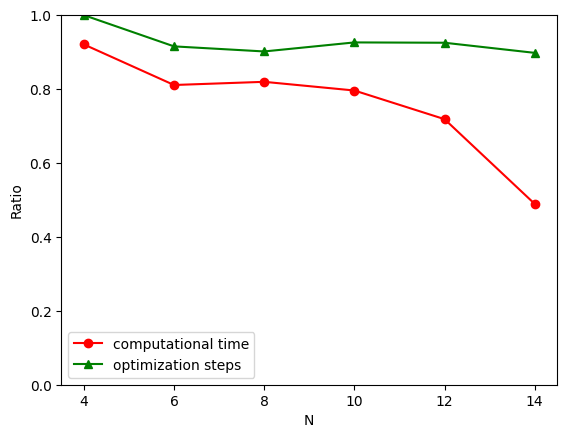

In [10]:
file=open('../files/Analysis_wrong_INTERP.dat','w')
file.write('COMPARISON BETWEEN "RIGHT" AND "WRONG" INTERP REGARDING TIME SAVING\n')
file.write('N   p   parameters_right    parameters_wrong    time_right    time_wrong    step_right   step_wrong\n')
time_saving=[]
step_saving=[]
for p in range(2,8):
    result_wrong,comput_time_wrong,step_wrong=wrong_INTERP(p)
    result,comput_time,step=optimization_via_INTERP(int(2*p),p)
    file.write(str(2*p))
    file.write('\n')
    file.write(str(p))
    file.write('\n')
    np.savetxt(file,result.optimal_point)
    np.savetxt(file,result_wrong.optimal_point)
    file.write(str(comput_time))
    file.write('\n')
    file.write(str(comput_time_wrong))
    file.write('\n')
    file.write(str(step))
    file.write('\n')
    file.write(str(step_wrong))
    file.write('\n')
    time_saving.append(comput_time_wrong/comput_time)
    step_saving.append(step_wrong/step)
Nx=np.arange(4,16,2)
plt.plot(Nx,time_saving,color='red',marker='o')
plt.plot(Nx,step_saving,color='green',marker='^')
plt.xlabel('N')
plt.ylabel('Ratio')
plt.ylim([0,1])
plt.legend(['computational time','optimization steps'])
plt.show()
file.close()

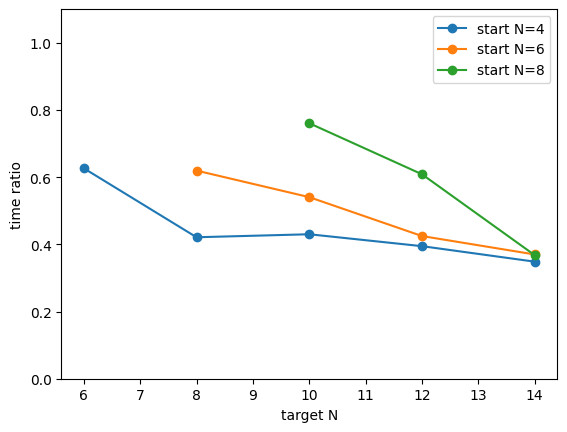

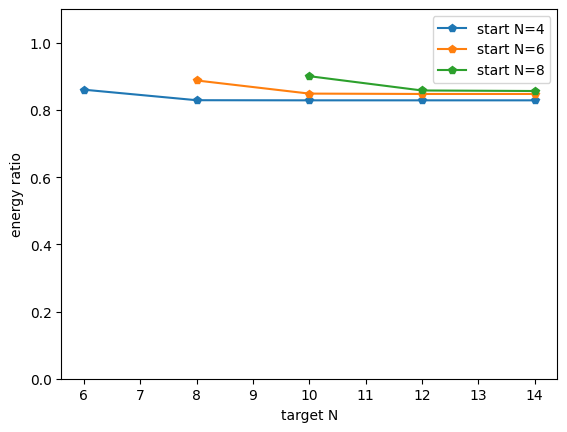

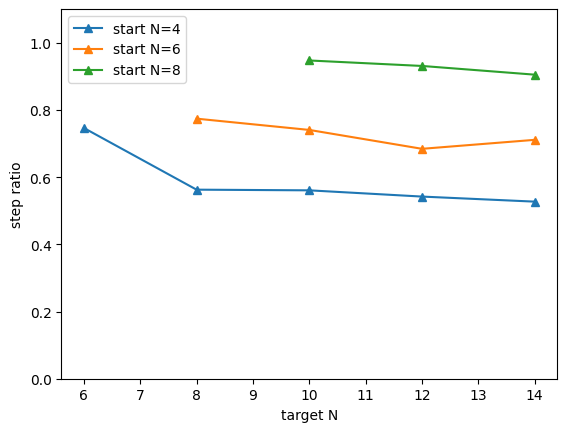

In [10]:
#OTTIMIZZO CON N=4,6,8 E P=7 (SO CHE TROVO IL GS)
#TRASFERISCO I PARAMETRI A N=(6,8),10,12,14 E VEDO L'ENERGIA ONE-SHOT E QUELLA CON REFINEMENT OPTIMIZATION
#FACCIO IL RAPPORTO TRA ENERGIA ONE-SHOT E QUELLA MIGLIORE
#PRENDO ANCHE IL TEMPO COMPUTAZIONALE (STEP) TOTALE (OTT. N=4,6,8+REFINEMENT) 
#E LO RAPPORTO AL TEMPO NORMALE DELL'INTERP CON N=10,12,14
p=7
estimator=Estimator()
optimizer=partial(opt,method='L-BFGS-B')
file=open('../files/Transferability.dat','w')
file.write('COMPARISON BETWEEN C-TIME OF TRANSFERRED/NON-TRANSF. PARAMS AND ENERGY RATIO ACQUIRED IN THE REFINEMENT OPT')
file.write('N_start N_target p=7 opt_params_refinement opt_total_params start_energy opt_energy tot_energy\n transf_time tot_time step_transf step_tot\n')
complete_res={}
complete_t={}
complete_step={}
for N in range(6,16,2):
    complete_res[str(N)],complete_t[str(N)],complete_step[str(N)]=optimization_via_INTERP(N,p)
for N in [4,6,8]:
    result,comput_time,step=optimization_via_INTERP(N,p)
    time_fraction=[]
    energy_fraction=[]
    step_fraction=[]
    for N_target in range(N+2,16,2):
        Hz,Hx,Hzz=create_hamiltonian(N_target)
        Htot=gzz*Hzz+gx*Hx+gz*Hz
        qc=create_parameterized_circuit(N_target,p)
        energy_one_shot=expectation_value(result.optimal_point,estimator,qc,Htot)
        start_time=time()
        refinement=VQE(estimator,qc,optimizer,initial_point=result.optimal_point).compute_minimum_eigenvalue(Htot)
        end_time=time()
        c_time=end_time-start_time
        file.write(str(N))
        file.write('   ')
        file.write(str(N_target))
        file.write('\n')
        np.savetxt(file,refinement.optimal_point)
        file.write('\n')
        np.savetxt(file,complete_res[str(N_target)].optimal_point)
        file.write('\n')
        file.write(str(energy_one_shot))
        file.write('\n')
        file.write(str(refinement.optimal_value))
        file.write('\n')
        file.write(str(complete_res[str(N_target)].optimal_value))
        file.write('\n')
        file.write(str(c_time+comput_time))
        file.write('\n')
        file.write(str(complete_t[str(N_target)]))
        file.write('\n')
        file.write(str(step+refinement.cost_function_evals))
        file.write('\n')
        file.write(str(complete_step[str(N_target)]))
        file.write('\n')
        time_fraction.append((c_time+comput_time)/complete_t[str(N_target)])
        energy_fraction.append(energy_one_shot/refinement.optimal_value)
        step_fraction.append((step+refinement.cost_function_evals)/complete_step[str(N_target)])
    N_target=np.arange(N+2,16,2)
    plt.figure(1)
    plt.plot(N_target,time_fraction,marker='o')
    plt.figure(2)
    plt.plot(N_target,energy_fraction,marker='p')
    plt.figure(3)
    plt.plot(N_target,step_fraction,marker='^')
file.close()  
plt.figure(1)
plt.xlabel('target N')
plt.ylabel('time ratio')
plt.ylim([0,1.1])
plt.legend(['start N=4','start N=6','start N=8'])
plt.figure(2)
plt.xlabel('target N')
plt.ylabel('energy ratio')
plt.ylim([0,1.1])
plt.legend(['start N=4','start N=6','start N=8'])
plt.figure(3)
plt.xlabel('target N')
plt.ylabel('step ratio')
plt.ylim([0,1.1])
plt.legend(['start N=4','start N=6','start N=8'])